# Project 10 - Wordle

Nicholas Colan

# Introduction

Wordle is a simple $5$ x $6$ grid based puzzle game that challenges the player to find the correct five-letter word in six guesses. To help the player guess the correct word within the six alloted guesses, the game will give a letter by letter feedback for each guess. 

If a letter's grid is colored `gray`, that means that letter does not appear in the puzzle's answer. If a letter's grid is colored `yellow`, that means that the letter does appear in the puzzle's answer, but it is currently not in the correct position. And if a letter's grid is colored `green`, that letter appears in the puzzle's answer in that same position. The puzzle is thereby solved when every letter tile is colored `green`.

In this project we will analyze every possible word that can appear in this iteration of Wordle, and see how different starting word guesses affect the number of guesses needed to solve the Wordle puzzle.

Here is an example of a wordle game:

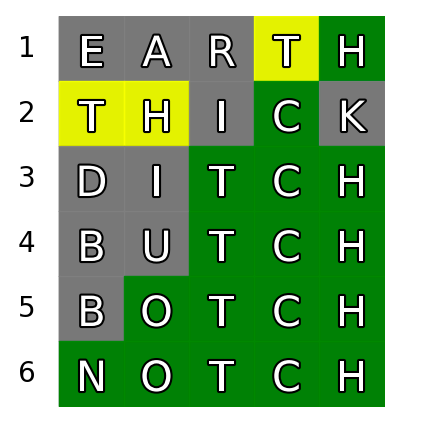

In [1]:
from IPython.display import Image
Image('wordleExample.png')

In [45]:
import requests
from wordle import *
from random import randrange
import matplotlib.pyplot as plt
import numpy as np

In [46]:
%config InlineBackend.figure_format = 'retina' # Used to sharpen image

We will first start off by downloading the Wordle game and its wordbank from an website using the `requests` package:

In [ ]:
#wordleURL = 'https://jllottes.github.io/_static/projects/wordle.py'
#with open('wordle.py','wb') as f:
    #f.write(requests.get(wordleURL).content)

In [ ]:
#wordsURL = 'https://jllottes.github.io/_downloads/a4a5f6debb229114cdac858c5a85657d/wordle_words.txt'
#with open('wordle_words.txt','wb') as f:
    #f.write(requests.get(wordsURL).content)

With our data saved in $2$ seperate files, we will now read in all the words used by this game and then run an instance of the Wordle game:

In [3]:
with open('wordle_words.txt','r') as f:
    words = f.read().split()

In [ ]:
%matplotlib notebook

game = wordle_game(words)
game.play()

# Data Analysis

With the Wordle game demonstrated, we can now run analysis of each word to see on average how many guesses it takes to solve the puzzle with each starting word.

Our first method, `get_possible_words()`, takes in the guessed word, its evaluation vs the correct word, and the word bank to generate a list of possible answers to the Wordle puzzle. This method will assume that there are no repeated letters in the answer, and we will use a `set` to generate a list of possible words. `Sets` do not contain repeated index values, so they will ensure that there are no repeated letters.

In [4]:
def get_possible_words(guess_word,evaluation,words):
    
    known_letters_known_positions = [(i,letter) for i,letter in enumerate(guess_word) if evaluation[i] == 2]
    known_letters_unknown_positions = [(i,letter) for i,letter in enumerate(guess_word) if evaluation[i] == 1]
    known_missing_letters = [letter for i,letter in enumerate(guess_word) if evaluation[i] == 0]
    
    words_without_duplicates = [word for word in words if len(set(word)) == len(word)]
    possible_words = list(words_without_duplicates)

    for word in words_without_duplicates:
        removed = False
        for i,letter in known_letters_known_positions:
            if word[i] != letter:
                possible_words.remove(word)
                removed = True
                break
        if not removed:
            for i,letter in known_letters_unknown_positions:
                if not (letter in word and word[i] != letter):
                    possible_words.remove(word)
                    removed = True
                    break
        if not removed:
            for letter in known_missing_letters:
                if letter in word:
                    possible_words.remove(word)
                    removed = True
                    break
    
    return possible_words

We will now modify `get_possible_words()` to be able to consider all words, even ones with repeating letters. This will be accomplished by using a `list`, which allows for repeated index values.

In [5]:
def modified_get_possible_words(guess_word,evaluation,words):
    
    known_letters_known_positions = [(i,letter) for i,letter in enumerate(guess_word) if evaluation[i] == 2]
    known_letters_unknown_positions = [(i,letter) for i,letter in enumerate(guess_word) if evaluation[i] == 1]
    known_missing_letters = [letter for i,letter in enumerate(guess_word) if evaluation[i] == 0]
    
    possible_words = list(words)

    for word in words:
        remaining_letters = list(word)
        removed = False
        for i,letter in known_letters_known_positions:
            if word[i] != letter:
                possible_words.remove(word)
                removed = True
                break
            else:
                remaining_letters.remove(letter)
        if not removed:
            for i,letter in known_letters_unknown_positions:
                if not (letter in remaining_letters and word[i] != letter):
                    possible_words.remove(word)
                    removed = True
                    break
                else:
                    remaining_letters.remove(letter)
        if not removed:
            for letter in known_missing_letters:
                if letter in remaining_letters:
                    possible_words.remove(word)
                    removed = True
                    break
    return possible_words

Now will declare `solve_wordle()`, a method that will solve the puzzle and return the puzzle's answer as well as the number of guesses needed by the function to solve the Worlde.

This function uses `random.randrange()` to randomly pick a guess word from the list of possible answers to the puzzle in an effort to more closely model a player's behavior when trying to solve the Wordle.

In [6]:
def solve_wordle(correct_word,guess_word,words):
    num_guesses = 1
    possible_words = list(words)
    evaluation = evaluate_guess(correct_word,guess_word)
    possible_words = modified_get_possible_words(guess_word,evaluation,possible_words)
    
    while(len(possible_words)>1):
        num_guesses+=1
        r = randrange(len(possible_words)-1)
        guess_word = possible_words[r]
        evaluation = evaluate_guess(correct_word,guess_word)
        possible_words = modified_get_possible_words(guess_word,evaluation,possible_words)
    
    return (possible_words[0], num_guesses)

Now we will look at $20$ different words in the Wordle puzzle wordbank to see what starting guessing on average solve the Wordle in the fewest number of attempts. We will first create a dictionary of the form `dict{word:float}` to track these word's average attempts needed to solve.

In [7]:
avgNumOfGuessesNeeded = {w:0.0 for w in words[:20]}

We will now create a method `avgGuesses()` that will take in a word and the list of all words in the Wordle game and will return the average number of guesses needed to solve the puzzle for each Wordle word. We will run the simulation $2,315$ times, testing each of our words for every potential Wordle puzzle.

In [8]:
def avgGuesses(guessWord,listWords):
    guesses = 0.0
    for w in listWords:
        guesses += solve_wordle(w,guessWord,listWords)[1]
    return guesses / len(listWords)

Now that we have a function that can simulate how well each word does, we can some of our Wordle words. Because we are going to test each starting guess against every possible Wordle word, $2315$ of them, it will take a while to test every word. Because of that we are only going to look at $20$ words, which should take roughly $5$ minutes.

In [9]:
for w in words[:20]:
    avgNumOfGuessesNeeded[w] = avgGuesses(w,words)

In [10]:
avgNumOfGuessesNeeded

{'CIGAR': 3.4086393088552915,
 'REBUT': 3.358099352051836,
 'SISSY': 3.8259179265658747,
 'HUMPH': 3.6358531317494602,
 'AWAKE': 3.69244060475162,
 'BLUSH': 3.3870410367170627,
 'FOCAL': 3.3904967602591793,
 'EVADE': 3.650107991360691,
 'NAVAL': 3.582289416846652,
 'SERVE': 3.535205183585313,
 'HEATH': 3.5598272138228944,
 'DWARF': 3.4436285097192223,
 'MODEL': 3.3434125269978403,
 'KARMA': 3.5913606911447085,
 'STINK': 3.3874730021598274,
 'GRADE': 3.326133909287257,
 'QUIET': 3.566738660907127,
 'BENCH': 3.3982721382289416,
 'ABATE': 3.5028077753779696,
 'FEIGN': 3.3956803455723543}

We want to be able to access these scores in a sorted format in order to look at the starting guesses which yielded the lowest amount of necessary guesses to solve the puzzle. Dictionary's cannot be sorted so to do that we will create a list of the `(key,value)` pairs from our dictionary.

In [11]:
words_list = []

for i in sorted(avgNumOfGuessesNeeded, key=avgNumOfGuessesNeeded.get, reverse=False):
    words_list.append([i,avgNumOfGuessesNeeded[i]])

In [12]:
words_list

[['GRADE', 3.326133909287257],
 ['MODEL', 3.3434125269978403],
 ['REBUT', 3.358099352051836],
 ['BLUSH', 3.3870410367170627],
 ['STINK', 3.3874730021598274],
 ['FOCAL', 3.3904967602591793],
 ['FEIGN', 3.3956803455723543],
 ['BENCH', 3.3982721382289416],
 ['CIGAR', 3.4086393088552915],
 ['DWARF', 3.4436285097192223],
 ['ABATE', 3.5028077753779696],
 ['SERVE', 3.535205183585313],
 ['HEATH', 3.5598272138228944],
 ['QUIET', 3.566738660907127],
 ['NAVAL', 3.582289416846652],
 ['KARMA', 3.5913606911447085],
 ['HUMPH', 3.6358531317494602],
 ['EVADE', 3.650107991360691],
 ['AWAKE', 3.69244060475162],
 ['SISSY', 3.8259179265658747]]

In [13]:
x_values = [i[0] for i in words_list]
y_values = [i[1] for i in words_list]
x_ticks = np.arange(len(x_values))

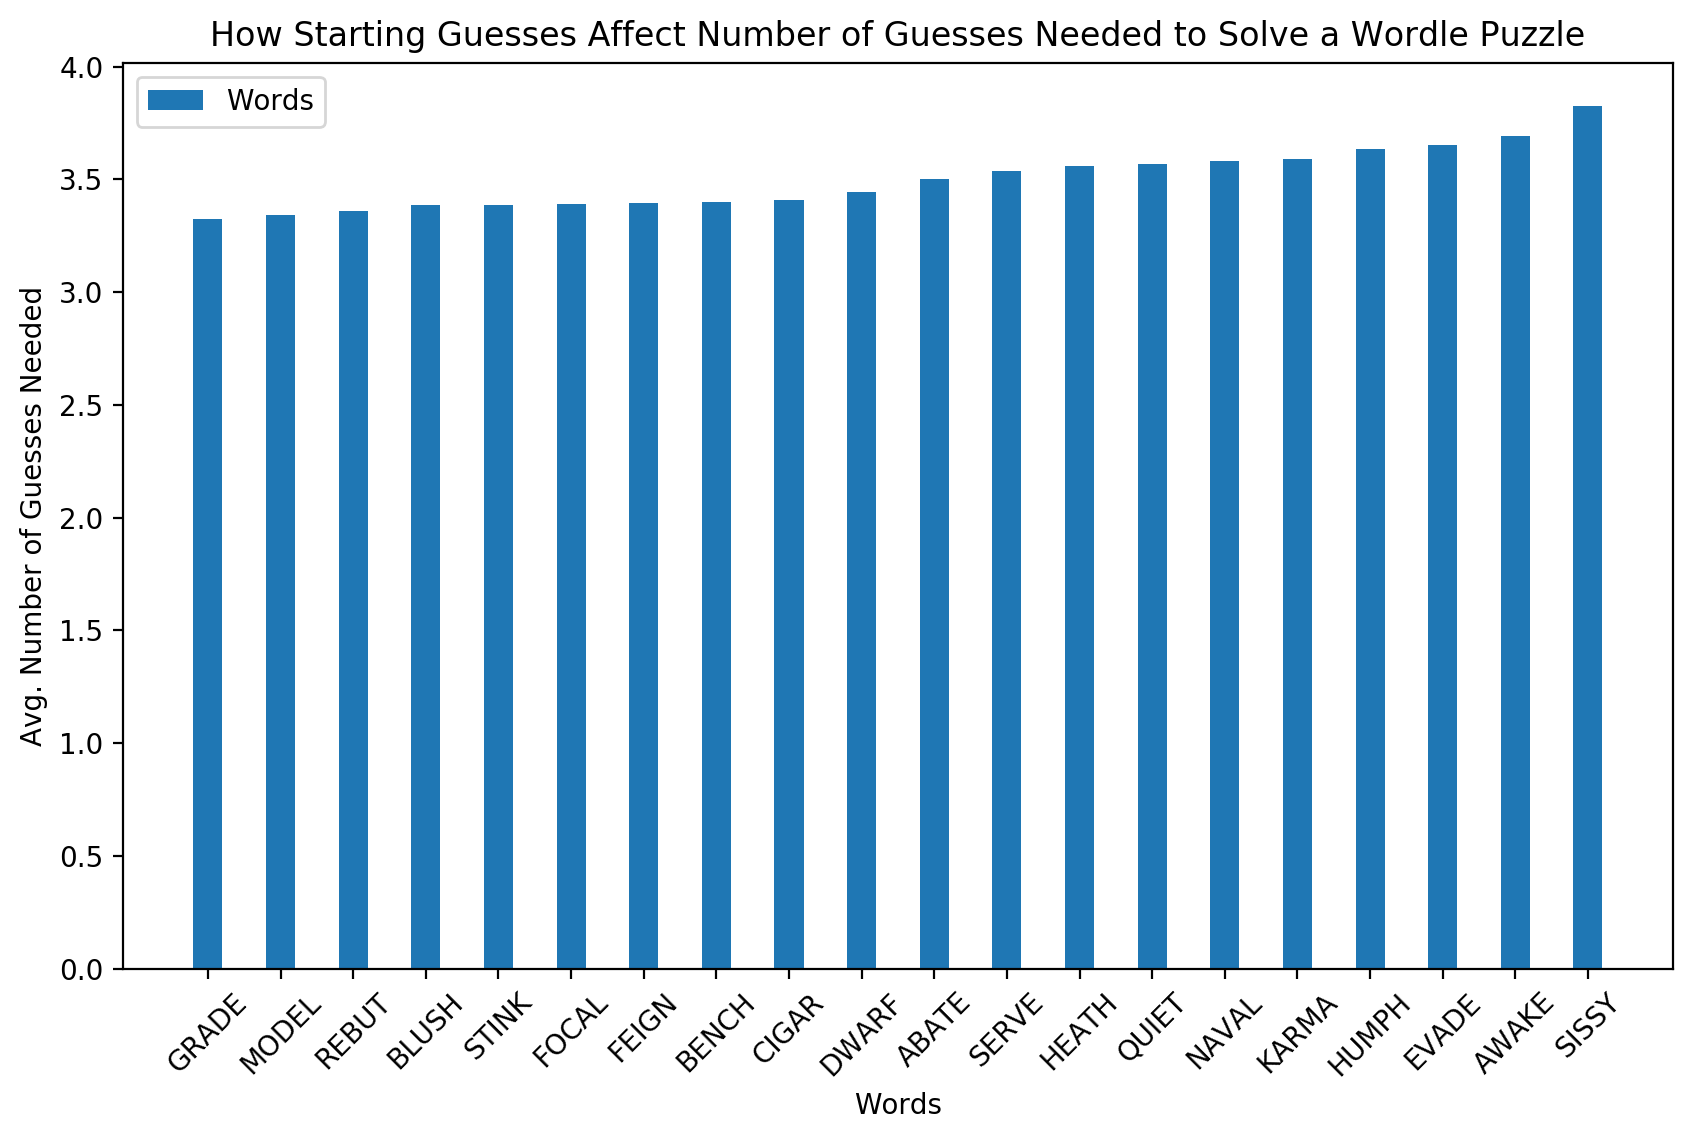

In [47]:
plt.figure(figsize=(10,6),dpi=100)

plt.bar(x_ticks,y_values,width=0.4,label='Words')
plt.xticks(x_ticks,x_values,rotation=45)
plt.xlabel('Words')
plt.ylabel('Avg. Number of Guesses Needed')
plt.title('How Starting Guesses Affect Number of Guesses Needed to Solve a Wordle Puzzle')
plt.legend()

plt.show()

As we can see from the $20$ words that we chose, `GRADE`,`MODEL`, and `REBUT` were the best starting choices on average. These words all contain no repeated letters as well as $2$ vowels. These words also start with consonants. Because these words all have these attributes, it is easy to see why they would be good candidates for a starting Wordle guess vs words like `SISSY`, which has the letter `S` $3$ times as well as only $1$ vowel. 

# Conclusion

A good strategy for starting a Wordle game is to use a word which will give you the most information about  the puzzle's answer. Words that contain multiple vowels as well as words that don't contain repeated letters are good candidates. Avoiding words that contain multiple occurences of the same letter is a good strategy for your first guess, as you are less likely to extract valuable information about the next guess with these types of words.

# Faster Wordle Solver 

Now let's see if we can create an algorithm that can solve a Wordle puzzle more efficiently. To do this, we will start by checking every word in our Wordle wordbank and assign a score for each word based on how well it does as a first guess. Because we are testing each of the $2,315$ possible words $2,315$ times, we are running $5,359,225$ simulations. This will take quite a long time and we will save these results in a file named `word_scores.txt` for quick access in the future.

I have already run tests for each word and will include the file `word_scores.txt` with my submission on UBLearns for quick access while reviewing this section of the report. Below I have included commented-out code which generates and saves this data

In [ ]:
#for w in words[]:
    #avgNumOfGuessesNeeded[w] = avgGuesses(w,words)

In [ ]:
#with open('word_scores.txt','w') as f:
    #for (key,value) in avgNumOfGuessesNeeded.items():
        #f.write('{:} - {:}\n'.format(key,value))

We need to retrieve this data in order to build our faster Wordle solving method. It will be stored in a dictionary named `avg_guesses_needed_all`.

In [15]:
avg_guesses_needed_all = {}

In [16]:
filename = 'word_scores.txt'

In [17]:
with open(filename,'r') as f:
    for line in f:
        (key,value) = line.split(' - ')
        value = float(value.rstrip('\n'))
        avg_guesses_needed_all[key] = value

We now need to sort this information by ascending values, in order to be able to easily access the words that take the fewest amount of guesses.

In [18]:
all_words_list = []

for i in sorted(avg_guesses_needed_all, key=avg_guesses_needed_all.get, reverse=False):
    all_words_list.append([i,avg_guesses_needed_all[i]])

We now have a place for our algorithm to start out at, but these "scores" are only meaningful for our first guess. We need ranked data for our algorithm to base its guess off of once it gets past the first guess. To do that we need to look through our Wordle word data and look for tendencies in the words. We will look at the first letter of each word to see what letters are most commonly the first letter of a word in the Wordle wordbank and use that towards our decision making process after the first guess.

We will start off by creating a dictionary to keep track of occurences of first letters named `first_letter_frequency`.

In [19]:
first_letter_frequency = {}

Now let's look through the word bank and track the occurence of every letter as a first digit. We will first create a method named `first_letter()` that takes in a string as an input and returns a string signifying the first letter of that word. This method assumes that its input is a valid word.

In [20]:
def first_letter(word:str):
    return word[0]

Now we can iterate through `words` to track each occurence:

In [21]:
for w in words:
    firstL = first_letter(w)
    if firstL in first_letter_frequency:
        first_letter_frequency[firstL]+=1
    else:
        first_letter_frequency[firstL]=1

The only letter not present as the first letter is `X`. Let's sort this data by its number of occurences in descending order.

In [22]:
first_letter_list = []

for i in sorted(first_letter_frequency, key=first_letter_frequency.get, reverse=True):
    first_letter_list.append([i,first_letter_frequency[i]])

In [23]:
first_letter_list.append(['X',])

In [49]:
first_letter_list

[['S', 366],
 ['C', 198],
 ['B', 173],
 ['T', 149],
 ['P', 142],
 ['A', 141],
 ['F', 136],
 ['G', 115],
 ['D', 111],
 ['M', 107],
 ['R', 105],
 ['L', 88],
 ['W', 83],
 ['E', 72],
 ['H', 69],
 ['V', 43],
 ['O', 41],
 ['N', 37],
 ['I', 34],
 ['U', 33],
 ['Q', 23],
 ['K', 20],
 ['J', 20],
 ['Y', 6],
 ['Z', 3],
 ['X']]

We can see that `S`,`C`,`B`, and `T` are the most common first letters in our word bank. Let's now do the same for the last letters.

In [50]:
last_letter_frequency = {}

In [51]:
def last_letter(word:str):
    return word[-1]

In [52]:
for w in words:
    lastL = last_letter(w)
    if lastL in last_letter_frequency:
        last_letter_frequency[lastL]+=1
    else:
        last_letter_frequency[lastL]=1

In [53]:
last_letter_list = []

for i in sorted(last_letter_frequency, key=last_letter_frequency.get, reverse=True):
    last_letter_list.append([i,last_letter_frequency[i]])

In [54]:
last_letter_list.append(['J',0])
last_letter_list.append(['Q',0])
last_letter_list.append(['V',0])

In [55]:
last_letter_list 

[['E', 424],
 ['Y', 364],
 ['T', 253],
 ['R', 212],
 ['L', 156],
 ['H', 139],
 ['N', 130],
 ['D', 118],
 ['K', 113],
 ['A', 64],
 ['O', 58],
 ['P', 56],
 ['M', 42],
 ['G', 41],
 ['S', 36],
 ['C', 31],
 ['F', 26],
 ['W', 17],
 ['B', 11],
 ['I', 11],
 ['X', 8],
 ['Z', 4],
 ['U', 1],
 ['J', 0],
 ['Q', 0],
 ['V', 0]]

We can now build our fast wordle solving bot. Our bot will first use one of the top $5$ rated starting guesses as its initial guess. From there it will look at the return from `evaluate_guess` to see what is known about the answer to the Wordle. If the starting letter is still unknown, it will use a word from `modified_get_possible_words` that has highest rated first letter in `first_letter_list`. If the starting letter is known but the last letter is not, it will use a word from `modified_get_possible_words` that has highest rated last letter in `last_letter_list`.

We will first need functions that will act as a key to sort our list of possible words by the most likely first/last letters, `sort_FL()` and `sort_LL()`. 

In [31]:
def sort_FL(s:str):
    for i in range(len(first_letter_list)-1):
        if first_letter(s)==first_letter_list[i][0]:
            return i

In [32]:
def sort_LL(s:str):
    for i in range(len(last_letter_list)-1):
        if last_letter(s)==last_letter_list[i][0]:
            return i

In [33]:
def fast_wordle_solver_1(correct_word,wordsList,firstLetters,lastLetters):
    num_guesses = 0
    answer = ''
    possible_words = list(wordsList)
    guess_word = all_words_list[randrange(5)][0]
    num_guesses+=1
    evaluation = evaluate_guess(correct_word,guess_word)
    possible_words = modified_get_possible_words(guess_word,evaluation,possible_words)
    
    while(len(possible_words)>1):
        num_guesses+=1
        if evaluation[0]!=2: # We will now use the word with the highest rated first letter
            guess_word = sorted(possible_words, key=sort_FL)[0]
            evaluation = evaluate_guess(correct_word,guess_word)
            possible_words = modified_get_possible_words(guess_word,evaluation,possible_words)
            
        elif evaluation[-1]!=2: # We will now use the word with the highest rated last letter
            guess_word = sorted(possible_words, key=sort_LL)[0]
            evaluation = evaluate_guess(correct_word,guess_word)
            possible_words = modified_get_possible_words(guess_word,evaluation,possible_words)
            
        else:
            r = randrange(len(possible_words)-1)
            guess_word = possible_words[r]
            evaluation = evaluate_guess(correct_word,guess_word)
            possible_words = modified_get_possible_words(guess_word,evaluation,possible_words)
            
    return possible_words[0], num_guesses                    

Now with our 'fast' wordle solver created, let's test it vs `solve_wordle()`. The method `solve_wordle()` requires a guess word for its input, so for that we will use a randomly selected word from our word bank. We will test each function for every word, $100$ times, to generate data that isn't as heavily influenced by 'lucky' Wordle games where the answers are found within $2$ guesses or games that take up to $6$ guesses. 

This will take a long time to run. I have already run these tests using the above two cells of code and will store them in a file named `solve_wordle_vs_fast_wordle_solver.txt` for quick access when reviewing this section of the report. 

In [34]:
#results_standard_fast_dict = {}

In [35]:
#for correct_word in words:
    #numGuesses_standard = 0
    #numGuesses_fast = 0
    #for i in range(100):
        #r = randrange(len(words)-1)
        #numGuesses_standard += solve_wordle(correct_word,words[r],words)[1]
        #numGuesses_fast += fast_wordle_solver_1(correct_word,words,first_letter_list,last_letter_list)[1]
    #results_standard_fast_dict[correct_word] = [numGuesses_standard / 100, numGuesses_fast / 100]

In [36]:
#with open('solve_wordle_vs_fast_wordle_solver.txt','w') as f:
    #for (key,value) in results_standard_fast_dict.items():
        #f.write('{:} - {:} | {:}\n'.format(key,value[0],value[1]))

This data can be quickly accessed using the code below:

In [37]:
standard_vs_fast_list = []
filename_s_vs_f = 'solve_wordle_vs_fast_wordle_solver.txt'

In [38]:
with open(filename_s_vs_f,'r') as f:
    for line in f:
        (key,value) = line.split(' - ')
        value1 = float(value.rstrip('\n').split(' | ')[0])
        value2 = float(value.rstrip('\n').split(' | ')[1])
        standard_vs_fast_list.append([key,value1,value2])

In [39]:
x_index = [i[0] for i in standard_vs_fast_list[:20]]
x_ticks = np.arange(len(x_index))

In [40]:
y_standard = [i[1] for i in standard_vs_fast_list]
y_fast = [i[2] for i in standard_vs_fast_list]

<function matplotlib.pyplot.show(*args, **kw)>

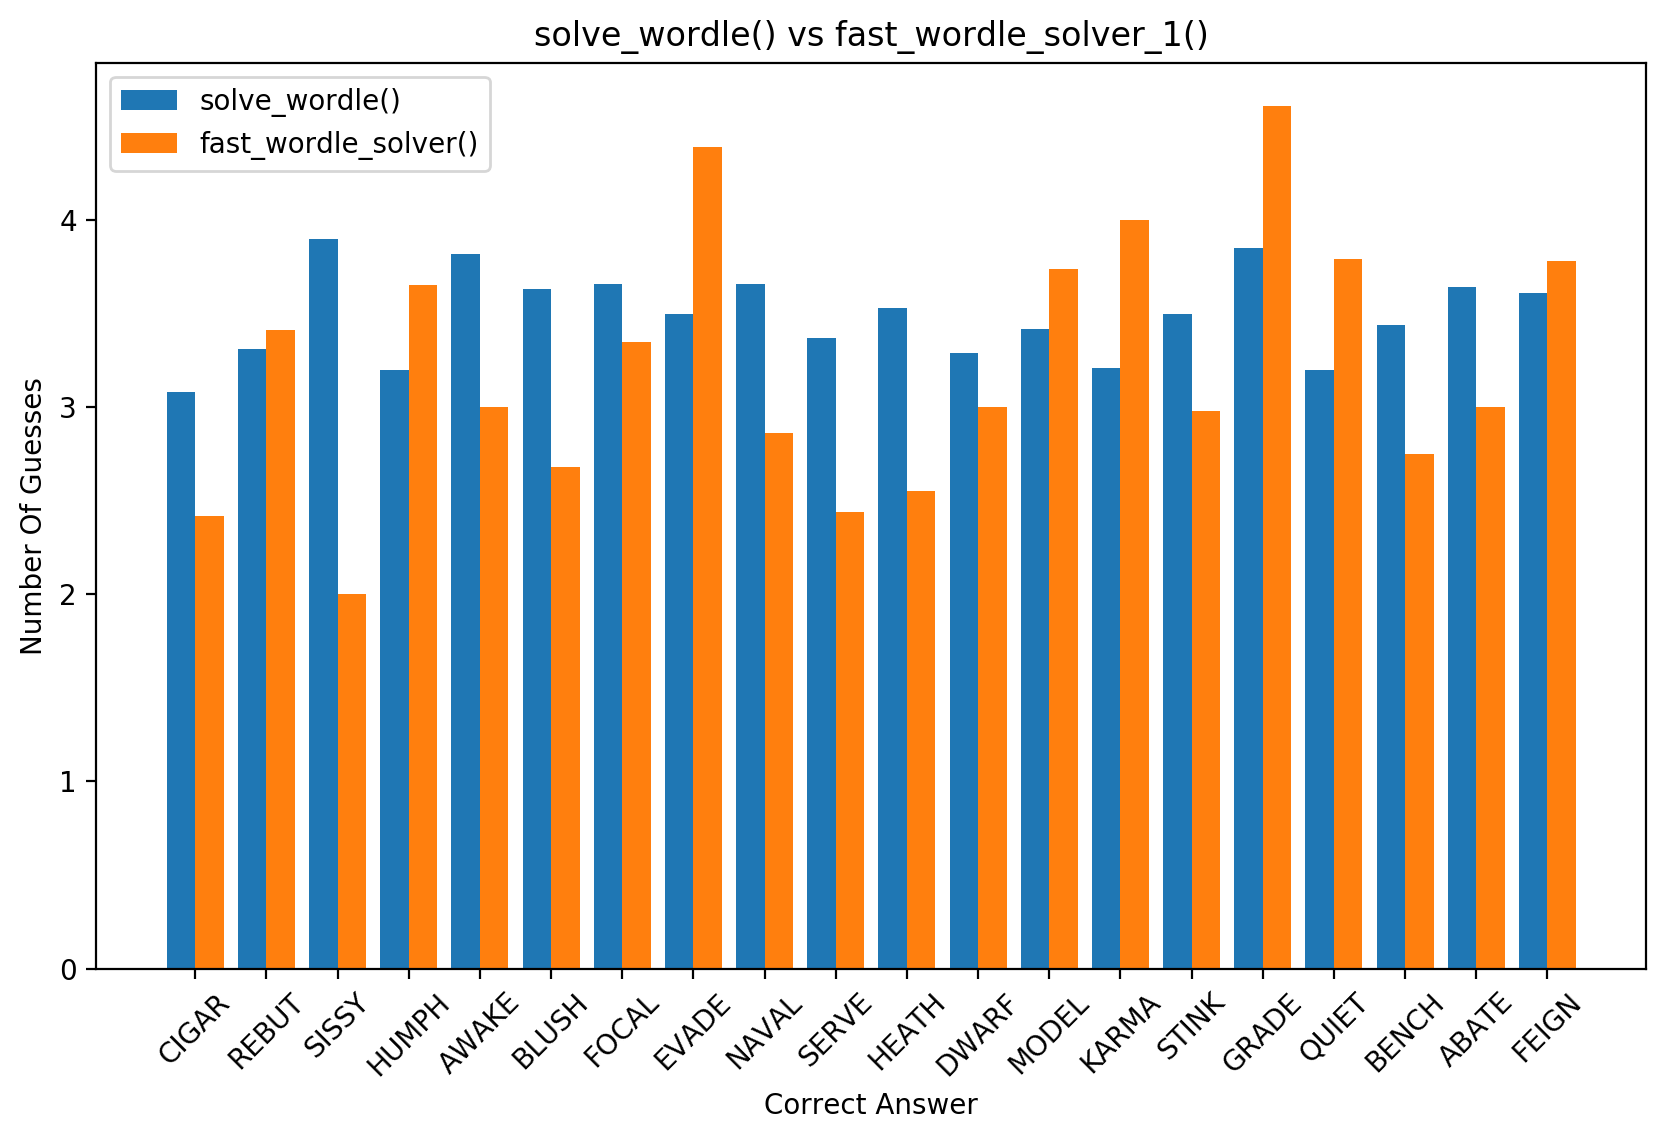

In [48]:
%matplotlib inline
plt.figure(figsize=(10,6),dpi=100)

plt.bar(x_ticks-0.2,y_standard[:20],width=0.4,label='solve_wordle()')
plt.bar(x_ticks+0.2,y_fast[:20],width=0.4,label='fast_wordle_solver()')

plt.xticks(x_ticks,x_index,rotation=45)
plt.xlabel('Correct Answer')
plt.ylabel('Number Of Guesses')
plt.title('solve_wordle() vs fast_wordle_solver_1()')
plt.legend()
plt.tight_layout
plt.show

In [42]:
standard_avg = 0
fast_avg = 0
for i in y_standard:
    standard_avg+=i
for i in y_fast:
    fast_avg+=i
standard_avg = standard_avg / len(y_standard)
fast_avg = fast_avg / len(y_fast)

print('Standard: ',standard_avg, ' | ', 'Fast: ',fast_avg)

Standard:  3.4589589632829294  |  Fast:  3.268453563714897


As we can see, our method `fast_wordle_solver_1()` does sucessfully solve a Wordle puzzle in less tries on average than `solve_wordle()`.